In [1]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

# Load Trained Model

In [3]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file('model\pipeline.config')
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join('model\checkpoint', 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# Detect from an Image

In [4]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
category_index = label_map_util.create_category_index_from_labelmap('label_map.pbtxt')

In [6]:
IMAGE_PATH = os.path.join('image', 'test', 'Cars425.png')

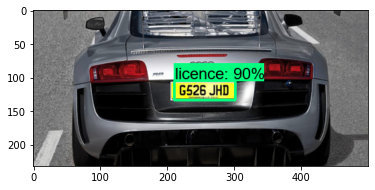

In [34]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Real Time Detections from Webcam

In [10]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# EASY OCR

In [11]:
detections.keys()

dict_keys(['detection_boxes', 'detection_scores', 'detection_classes', 'raw_detection_boxes', 'raw_detection_scores', 'detection_multiclass_scores', 'detection_anchor_indices', 'num_detections'])

In [11]:
!pip3 uninstall easyocr

^C


In [10]:
!pip3 uninstall torch torchvision torchaudio 

^C


In [14]:
import easyocr

In [15]:
detection_threshold = 0.7

In [35]:
image = image_np_with_detections
scores = list(filter(lambda x: x > detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [36]:
width = image.shape[1]
height = image.shape[0]

In [37]:
width

500

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[0.45260367 0.4203717  0.57693446 0.6058703 ]
[105.00405097 210.18585563 133.84879398 302.93515325]
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete[([[4, 2], [86, 2], [86, 26], [4, 26]], '6526 JHD', 0.6684808252219833)]


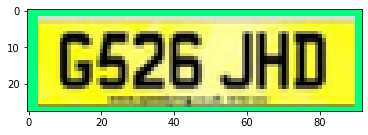

In [21]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(box)
    roi =  box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]), int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

In [29]:
region_threshold = 0.5

In [38]:
def filter_text(region, ocr_result, region_threshold):
    rectangle_size = region.shape[0]*region.shape[1]
    
    plate=[]
    for result in ocr_result:
        length = np.sum(np.subtract(result[0][1], result[0][0]))
        height = np.sum(np.subtract(result[0][2], result[0][1]))
        
        if length*height / rectangle_size > region_threshold:
            plate.append(result[1])
        
    return plate

In [39]:
filter_text(region, ocr_result, region_threshold)

[]

In [40]:
def ocr_it(image, detections, detection_threshold, region_threshold):
    
    #Scores, boxes and classes
    scores = list(filter(lambda x: x > detection_threshold, detections['detection_scores']))
    boxes = detections['detection_boxes'][:len(scores)]
    classes = detections['detection_classes'][:len(scores)]
    
    # Full image dimensions
    width = image.shape[1]
    height = image.shape[0]
    
    # Apply ROI filtering and OCR
    for idx, box in enumerate(boxes):
        roi =  box*[height, width, height, width]
        region = image[int(roi[0]):int(roi[2]), int(roi[1]):int(roi[3])]
        reader = easyocr.Reader(['en'])
        ocr_result = reader.readtext(region)
        text = filter_text(region, ocr_result, region_threshold)
        plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
        print(text)
        return text, region

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['6526 JHD']


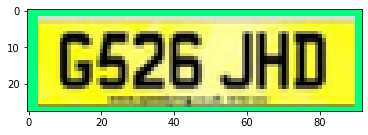

In [41]:
text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['L02 84P95]']


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


['L02 84P951']


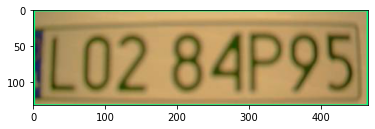

In [42]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)
    
    try:
        text, region = ocr_it(image_np_with_detections, detections, detection_threshold, region_threshold)
    except:
        pass

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

In [47]:
print(text)

['L02 84P951']
